In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

import torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
import torch.nn as nn
import numpy as np
import math
from tqdm import tqdm, trange
from math import sin, cos, sqrt, atan2, radians, exp
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# TASK 1

In [0]:
features, labels = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, shuffle=True)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

n_classes = len(np.unique(labels))
n_features = X_train.shape[1]

In [0]:
class SimulatedAnnealing(Optimizer):
    def __init__(self, params, loss, model, input_data, target,
                 init_temp=500, annealing_rate = 0.95):
        super(SimulatedAnnealing, self).__init__(params, defaults = {loss:loss, model:model, input_data:input_data, target:target,
                 init_temp: init_temp, annealing_rate : annealing_rate}) 
        self.init_temp = init_temp
        self.annealing_rate = annealing_rate
        self.curr_temp = init_temp
        self.loss = loss
        self.model = model
        self.input_data = input_data
        self.target = target
        self.iteration = 0
        self.sigma = 0.5

    def step(self):
        old_pred = self.model(self.input_data)
        old_loss = self.loss(old_pred, self.target)
        old_state_dict = {}
        for key in model.state_dict():
            old_state_dict[key] = self.model.state_dict()[key].clone()
        new_state_dict = {}
        for name, param in self.model.state_dict().items():
            new_state_dict[name]=self._sample(param).cuda()
        self.model.load_state_dict(new_state_dict)
        new_pred = self.model(self.input_data)
        new_loss = self.loss(new_pred, self.target)
        
        if (new_loss < old_loss):
            alpha = math.exp(-(new_loss + old_loss) / self.curr_temp) 
            if (np.random.uniform(0, 1) > alpha):
                self.model.load_state_dict(old_state_dict)
        else:
            self.model.load_state_dict(old_state_dict)
            
        if self.iteration % 3 == 0:
            self.curr_temp *= self.annealing_rate
        self.iteration += 1

    def _sample(self, weights):
      new_weights = np.zeros(weights.shape)
      if len(weights.shape) == 2:
        for i in range(weights.shape[0]):
            new_weights[i] = np.random.normal(weights[i].cpu().mean(), self.sigma, size=len(weights[i]))
      else:
        new_weights = np.random.normal(weights.cpu().mean(), self.sigma, size=len(weights))
      return torch.Tensor(new_weights)
         

In [0]:
class FeedForwardNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNeuralNet, self).__init__() 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax()
       
       
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal(m.weight, 0, 0.5)
        m.bias.data.fill_(0.01) 

In [0]:
def train(model, optimizer, is_grad_on=False):
  model.train()
  predicted = model(X_train)
  loss = criterion(predicted, y_train)
  if is_grad_on:
    loss.backward()
  predicted = np.argmax(predicted.cpu().detach().numpy(), 1)
  accuracy = accuracy_score(y_train.cpu().detach().numpy() , predicted)
  optimizer.step()

  return loss.item(), accuracy          
def test(model, optimizer):
  model.eval()  
  predicted = model(X_test)
  loss = criterion(predicted,y_test)
  predicted = np.argmax(predicted.cpu().detach().numpy(), 1)
  accuracy = accuracy_score(y_test.cpu().detach().numpy() , predicted)
  return loss.item(), accuracy


In [101]:
model = FeedForwardNeuralNet(n_features, 32, n_classes)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
model.apply(init_weights) 

if torch.cuda.is_available():
  model = model.cuda()
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

optimizer = SimulatedAnnealing(params = model.parameters(), model = model, loss = criterion, 
                               input_data = X_train, target = y_train, annealing_rate=0.95)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in trange(num_epochs, desc='Epochs', total=num_epochs):
    loss, accuracy = train(model,optimizer)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test(model,optimizer)
    test_loss.append(loss)
    test_accuracy.append(accuracy)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Epochs: 100%|██████████| 100/100 [00:00<00:00, 113.76it/s]


Text(0.5, 0, 'epochs')

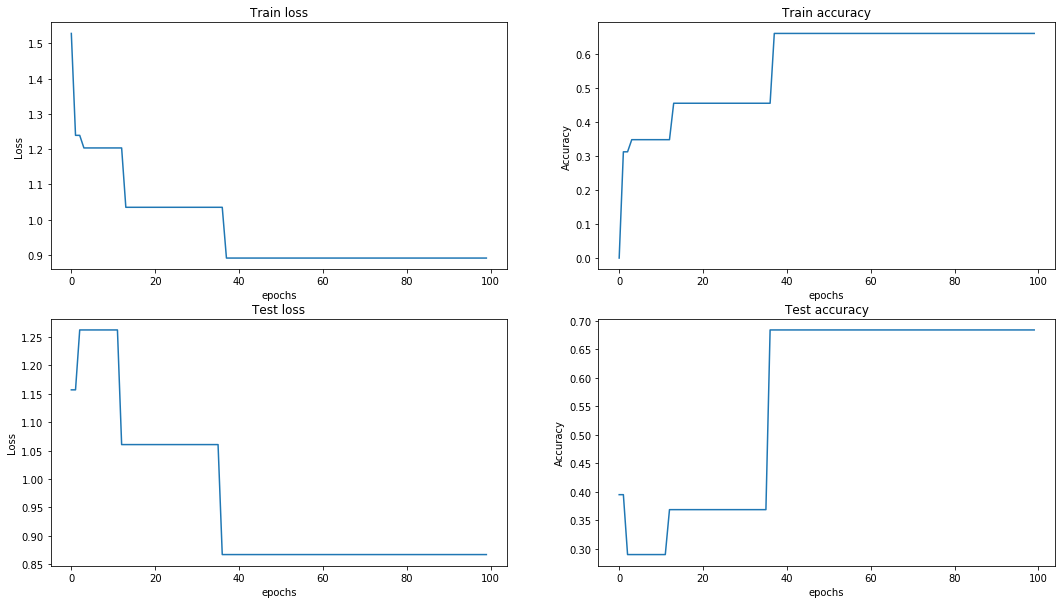

In [100]:
epoch = np.arange(0, num_epochs)
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18, 10)
axs[0, 0].plot(epoch, train_loss)
axs[0, 0].set_title('Train loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('epochs')

axs[0, 1].plot(epoch, train_accuracy)
axs[0, 1].set_title('Train accuracy')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('epochs')

axs[1, 0].plot(epoch, test_loss)
axs[1, 0].set_title('Test loss')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_xlabel('epochs')

axs[1, 1].plot(epoch, test_accuracy)
axs[1, 1].set_title('Test accuracy')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_xlabel('epochs')


In [104]:
model = FeedForwardNeuralNet(n_features, 32, n_classes)

if torch.cuda.is_available():
  model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in trange(num_epochs, desc='Epochs', total=num_epochs):
    loss, accuracy = train(model,optimizer, is_grad_on=True)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test(model,optimizer)
    test_loss.append(loss)
    test_accuracy.append(accuracy)


Epochs: 100%|██████████| 100/100 [00:00<00:00, 351.27it/s]


Text(0.5, 0, 'epochs')

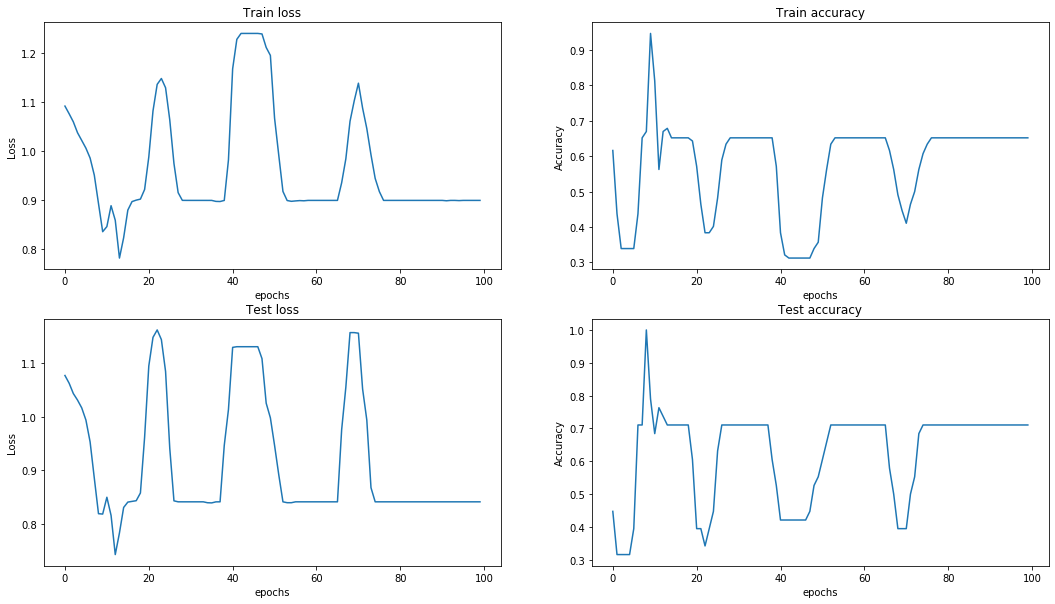

In [105]:
epoch = np.arange(0, num_epochs)
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18, 10)
axs[0, 0].plot(epoch, train_loss)
axs[0, 0].set_title('Train loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('epochs')

axs[0, 1].plot(epoch, train_accuracy)
axs[0, 1].set_title('Train accuracy')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('epochs')

axs[1, 0].plot(epoch, test_loss)
axs[1, 0].set_title('Test loss')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_xlabel('epochs')

axs[1, 1].plot(epoch, test_accuracy)
axs[1, 1].set_title('Test accuracy')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_xlabel('epochs')


# TASK 2

In [0]:
import pandas as pd
def read_cities_data(path='cities.csv'):
  data = pd.read_csv(path)
  data['population'] = data['population'].astype(int)
  sorted = data.sort_values(by=['population'], ascending=False)[:30]
  return {row['address'].split('г ')[1]:(row['geo_lat'], row['geo_lon']) for _, row in sorted.iterrows()}


In [0]:
# coordinates = read_cities_data()
coordinates ={'Барнаул': (53.3479968, 83.7798064),
 'Владивосток': (43.116490399999996, 131.8823937),
 'Волгоград': (48.7070042, 44.5170339),
 'Воронеж': (51.659333200000006, 39.1969229),
 'Екатеринбург': (56.8385216, 60.605491099999995),
 'Ижевск': (56.852738, 53.21148960000001),
 'Иркутск': (52.2864036, 104.28074659999999),
 'Казань': (55.7943584, 49.1114975),
 'Кемерово': (55.391065100000006, 86.0467781),
 'Краснодар': (45.0401604, 38.975964700000006),
 'Красноярск': (56.00938789999999, 92.85248059999999),
 'Махачкала': (42.9849159, 47.504718100000005),
 'Москва': (55.7540471, 37.620405),
 'Нижний Новгород': (56.3240627, 44.00539129999999),
 'Новокузнецк': (53.794315000000005, 87.2142745),
 'Новосибирск': (55.02819100000001, 82.9211489),
 'Омск': (54.9848566, 73.3674517),
 'Оренбург': (51.7875092, 55.1018828),
 'Пермь': (58.0102583, 56.2342034),
 'Ростов-на-Дону': (47.2224566, 39.718803),
 'Самара': (53.195030599999996, 50.1069518),
 'Санкт-Петербург': (59.9391313, 30.315900399999997),
 'Саратов': (51.5303047, 45.9529348),
 'Тольятти': (53.5205348, 49.3894028),
 'Тюмень': (57.1529744, 65.5344099),
 'Ульяновск': (54.307941500000005, 48.3748487),
 'Уфа': (54.73494399999999, 55.9578468),
 'Хабаровск': (48.4647258, 135.05989419999997),
 'Челябинск': (55.16026239999999, 61.400807799999995),
 'Ярославль': (57.62154770000001, 39.897741100000005)}

In [0]:
def get_energy(coordinates, path):
  path = np.array(path)
  dist = 0
  for city1, city2 in zip(path[:-1], path[1:]):
    dist+= get_dist(coordinates[city1], coordinates[city2])
  return dist

def get_dist(city1, city2):
  # city 1 - source, city2 - destination
  # approximate radius of earth in km
  R = 6373.0
  lat1 = radians(city1[0])
  lon1 = radians(city1[1])
  lat2 = radians(city2[0])
  lon2 = radians(city2[1])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  distance = R * c
  return distance


def get_acceptance_probability(energy, new_energy, temp):
        if new_energy < energy:
            return 1
        return exp((energy - new_energy) / temp)

def run_simulated_annealing(coordinates, cooling_rate=0.003, init_temp=1000, temp_min=1):
    best_path = list(coordinates.keys())
    cur_path = list(coordinates.keys())
    temp = init_temp
    best_energies = []
    history = []
    while temp > 1:
        pos1 = random.randint(0, len(coordinates)-1)
        pos2 = random.randint(0, len(coordinates)-1)

        new_path = cur_path.copy()
        new_path[pos1] = cur_path[pos2]
        new_path[pos2] = cur_path[pos1]

        if get_acceptance_probability(get_energy(coordinates, cur_path), get_energy(coordinates, new_path), temp) > random.random():
            cur_path = new_path
        
        if get_energy(coordinates, cur_path) < get_energy(coordinates, best_path):
          best_path = cur_path

        temp*=1-cooling_rate
        best_energies.append(get_energy(coordinates, best_path))
        history.append(best_path)
    return best_energies, history



In [0]:
def animate(i):
    ax.clear()
    cities = history[i]
    y = [coordinates[city][1] for city in cities]
    x = [coordinates[city][0] for city in cities]
    plt.plot(x, y, '-o')
    for j, txt in enumerate(cities):
        ax.annotate(txt, (x[j], y[j]))
    plt.axis('off')


# Slow cooling

Text(0, 0.5, 'Energy')

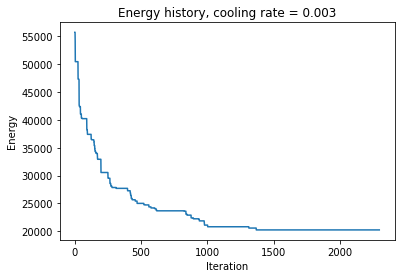

In [0]:
cooling_rate1 = 0.003
best_energies1, history = run_simulated_annealing(coordinates, cooling_rate=cooling_rate1)
plt.plot(np.arange(0, len(best_energies1)), best_energies1)
plt.title(f'Energy history, cooling rate = {cooling_rate1}')
plt.xlabel('Iteration')
plt.ylabel('Energy')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


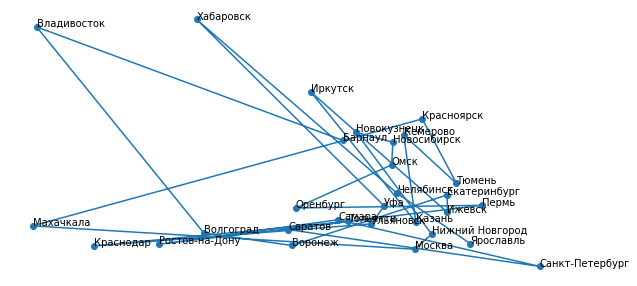

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.set_size_inches(10, 5)
ani = animation.FuncAnimation(fig, animate, frames=len(history))
ani.save(f'SimulatedAnnealing_{cooling_rate1}.gif', writer='imagemagick')

# Medium cooling

Text(0, 0.5, 'Energy')

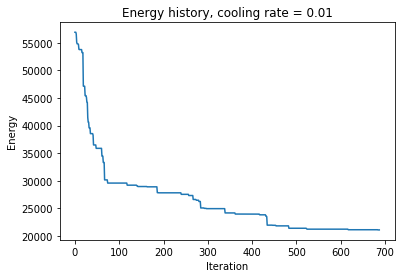

In [0]:
cooling_rate2 = 0.01
best_energies2, history = run_simulated_annealing(coordinates, cooling_rate=cooling_rate2)
plt.plot(np.arange(0, len(best_energies2)), best_energies2)
plt.title(f'Energy history, cooling rate = {cooling_rate2}')
plt.xlabel('Iteration')
plt.ylabel('Energy')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


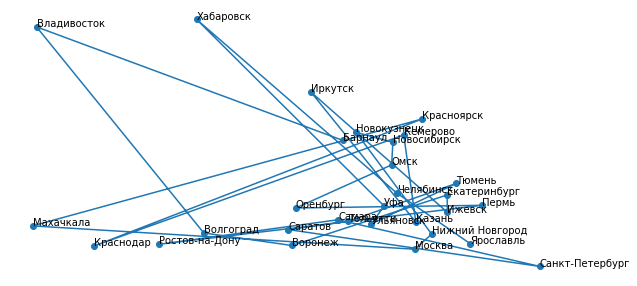

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.set_size_inches(10, 5)
ani = animation.FuncAnimation(fig, animate, frames=len(history))
ani.save(f'SimulatedAnnealing_{cooling_rate2}.gif', writer='imagemagick')


# Fast cooling

Text(0, 0.5, 'Energy')

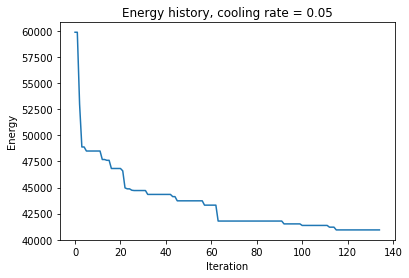

In [0]:
cooling_rate3 = 0.05
best_energies3, history = run_simulated_annealing(coordinates, cooling_rate=cooling_rate3)
plt.plot(np.arange(0, len(best_energies3)), best_energies3)
plt.title(f'Energy history, cooling rate = {cooling_rate3}')
plt.xlabel('Iteration')
plt.ylabel('Energy')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


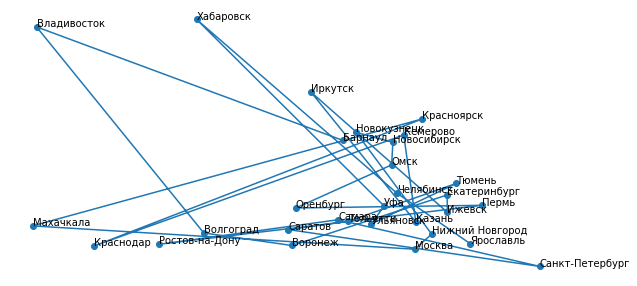

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.set_size_inches(10, 5)
ani = animation.FuncAnimation(fig, animate, frames=len(history))
ani.save(f'SimulatedAnnealing_{cooling_rate3}.gif', writer='imagemagick')
